# Formula 1 data pit stop - 1950 to 2023

## Non-spatial data source

Thanks to [Chris Newell](https://github.com/jcnewell) who administers an [f1-api](http://ergast.com/mrd/db/).

The database can also be downloaded as a set of CSV files which can be imported into spreadsheets and other types of software:

[f1db_csv.zip](http://ergast.com/downloads/f1db_csv.zip)

Each CSV file contains a single database table. The text encoding is UTF-8 and the first line of each file contains the column headers. The tables are described in the [User Guide](http://ergast.com/docs/f1db_user_guide.txt).

## Spatial data source

Thanks to Tomislav Bacinger for curating the circuit [geojson files](https://github.com/bacinger/f1-circuits/blob/master/f1-circuits.geojson).

### Import required packages

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import leafmap.foliumap as leafmap

### Data structure and schema

Before jumping in it is imperative that we spend a lot of time getting to know our data. It can sometimes feel a bit overwhelming with such a large volume of data, spread across a number of different tables (see the table schemas below) but by being methodical and making use of the pandas library in particular, we can start to take control of the wheel.

### Custom function to perform inital exploratory data analysis (EDA)

Let's create a custom function to automate some of our data wrangling :

In [2]:
def initial_eda(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensions : %d rows, %d columns" % (df.shape[0], df.shape[1]))
        print("Total NA Values : %d " % (total_na))
        print("%38s %10s     %10s %10s" % ("Column Name", "Data Type", "#Distinct", "NA Values"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%38s %10s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))
        
    else:
        print("Expect a DataFrame but got a %15s" % (type(df)))

### Drivers

In [3]:
# read in our data
drivers = pd.read_csv('formula_one/data/drivers.csv')

Now apply our custom function :

In [4]:
initial_eda(drivers)

Dimensions : 857 rows, 9 columns
Total NA Values : 0 
                           Column Name  Data Type      #Distinct  NA Values
                              driverId      int64          857          0
                             driverRef     object          857          0
                                number     object           45          0
                                  code     object           95          0
                              forename     object          476          0
                               surname     object          798          0
                                   dob     object          839          0
                           nationality     object           42          0
                                   url     object          857          0


In [5]:
# preview first 5 rows
drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [6]:
# concatenate driver names
drivers["name"] = drivers[["forename", "surname"]].apply(lambda x: " ".join(x), axis =1)

In [7]:
# drop columns of no interest
drivers.drop(['driverRef', 'number', 'forename', 'surname', 'url', 'code'], axis=1, inplace=True)

In [8]:
drivers.nationality.nunique()

42

In [9]:
drivers.nationality.unique()

array(['British', 'German', 'Spanish', 'Finnish', 'Japanese', 'French',
       'Polish', 'Brazilian', 'Italian', 'Australian', 'Austrian',
       'American', 'Dutch', 'Colombian', 'Portuguese', 'Canadian',
       'Indian', 'Hungarian', 'Irish', 'Danish', 'Argentine', 'Czech',
       'Malaysian', 'Swiss', 'Belgian', 'Monegasque', 'Swedish',
       'Venezuelan', 'New Zealander', 'Chilean', 'Mexican',
       'South African', 'Liechtensteiner', 'Rhodesian',
       'American-Italian', 'Uruguayan', 'Argentine-Italian', 'Thai',
       'East German', 'Russian', 'Indonesian', 'Chinese'], dtype=object)

In [10]:
drivers.describe()

,driverId
count,857.000000
mean,429.057176
std,247.632402
min,1.000000
25%,215.000000
50%,429.000000
75%,643.000000
max,858.000000


So we have information on 857 drivers representing 42 different nationalities.

### Circuits

In [11]:
# read in our data
circuits = pd.read_csv('formula_one/data/circuits.csv')

In [12]:
initial_eda(circuits)

Dimensions : 77 rows, 9 columns
Total NA Values : 0 
                           Column Name  Data Type      #Distinct  NA Values
                             circuitId      int64           77          0
                            circuitRef     object           77          0
                                  name     object           77          0
                              location     object           75          0
                               country     object           35          0
                                   lat    float64           77          0
                                   lng    float64           77          0
                                   alt     object           66          0
                                   url     object           77          0


Let's create a geometry column from the `lat` and `lng` values : 

In [13]:
circuits.head()

,circuitId,circuitRef,name,location,country,lat,lng,alt,url
0,1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_P...
1,2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_Internatio...
2,3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_Internati...
3,4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcel...
4,5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park


In [14]:
# Use a lambda function to create Point objects and assign them to the 'geometry' column
circuits['geometry'] = circuits.apply(lambda row: Point(row['lng'], row['lat']), axis=1)

In [15]:
circuits.country.nunique()

35

In [16]:
circuits.country.unique()

array(['Australia', 'Malaysia', 'Bahrain', 'Spain', 'Turkey', 'Monaco',
       'Canada', 'France', 'UK', 'Germany', 'Hungary', 'Belgium', 'Italy',
       'Singapore', 'Japan', 'China', 'Brazil', 'USA', 'United States',
       'UAE', 'Argentina', 'Portugal', 'South Africa', 'Mexico', 'Korea',
       'Netherlands', 'Sweden', 'Austria', 'Morocco', 'Switzerland',
       'India', 'Russia', 'Azerbaijan', 'Saudi Arabia', 'Qatar'],
      dtype=object)

So we have information on 77 race circuits across 35 different countries.

In [17]:
# drop columns of no interest
circuits.drop(['alt', 'url', 'circuitRef'], axis=1, inplace=True)
circuits

,circuitId,name,location,country,lat,lng,geometry
0,1,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,POINT (144.968 -37.8497)
1,2,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,POINT (101.738 2.76083)
2,3,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,POINT (50.5106 26.0325)
3,4,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,POINT (2.26111 41.57)
4,5,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,POINT (29.405 40.9517)
...,...,...,...,...,...,...,...
72,75,Autódromo Internacional do Algarve,Portimão,Portugal,37.22700,-8.62670,POINT (-8.6267 37.227)
73,76,Autodromo Internazionale del Mugello,Mugello,Italy,43.99750,11.37190,POINT (11.3719 43.9975)
74,77,Jeddah Corniche Circuit,Jeddah,Saudi Arabia,21.63190,39.10440,POINT (39.1044 21.6319)
75,78,Losail International Circuit,Al Daayen,Qatar,25.49000,51.45420,POINT (51.4542 25.49)


In [18]:
circuits.describe()

,circuitId,lat,lng
count,77.000000,77.000000,77.000000
mean,39.883117,33.442925,1.076683
std,23.001701,22.808866,65.516951
min,1.000000,-37.849700,-118.189000
25%,20.000000,32.777400,-9.394170
50%,40.000000,40.951700,3.930830
75%,59.000000,46.958900,19.248600
max,80.000000,57.265300,144.968000


### Circuit Maps

In [19]:
# create a GeoPandas DataFrame of circuits from geojson file
circuits_gdf = gpd.read_file('https://raw.githubusercontent.com/Stephen137/formula_one/main/data/f1-circuits.geojson')

In [20]:
print(type(circuits_gdf))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [21]:
initial_eda(circuits_gdf)

Dimensions : 35 rows, 8 columns
Total NA Values : 0 
                           Column Name  Data Type      #Distinct  NA Values
                                    id     object           35          0
                              Location     object           35          0
                                  Name     object           35          0
                                opened      int64           29          0
                               firstgp      int64           26          0
                              length_m      int64           34          0
                            altitude_m      int64           33          0
                              geometry   geometry           35          0


We only have maps for 35 circuits. So let's bear that in mind and filter our race stats to include only those that we have maps for.

In [22]:
circuit_names = list(circuits_gdf.Name.values)
circuit_names

['Albert Park Grand Prix Circuit',
 'Bahrain International Circuit',
 'Shanghai International Circuit',
 'Baku City Circuit',
 'Circuit de Barcelona-Catalunya',
 'Circuit de Monaco',
 'Circuit Gilles Villeneuve',
 'Circuit Paul Ricard',
 'Red Bull Ring',
 'Silverstone Circuit',
 'Hockenheimring',
 'Hungaroring',
 'Circuit de Spa-Francorchamps',
 'Autodromo Nazionale di Monza',
 'Marina Bay Street Circuit',
 'Sochi Autodrom',
 'Suzuka Circuit',
 'Circuit of the Americas',
 'Autódromo Hermanos Rodríguez',
 'Autódromo José Carlos Pace',
 'Yas Marina Circuit',
 'Autodromo Enzo e Dino Ferrari',
 'Nürburgring',
 'Autódromo Internacional do Algarve',
 'Autodromo Internazionale del Mugello',
 'Sepang International Circuit',
 'Istanbul Park',
 'Circuit Park Zandvoort',
 'Circuit de Nevers Magny-Cours',
 'Autódromo do Estoril',
 'Autódromo Internacional Nelson Piquet',
 'Jeddah Corniche Circuit',
 'Miami International Autodrome',
 'Losail International Circuit',
 'Las Vegas Strip Street Circuit'

### Races

In [23]:
# read in our data
races = pd.read_csv('formula_one/data/races.csv')

In [24]:
initial_eda(races)

Dimensions : 1101 rows, 18 columns
Total NA Values : 0 
                           Column Name  Data Type      #Distinct  NA Values
                                raceId      int64         1101          0
                                  year      int64           74          0
                                 round      int64           22          0
                             circuitId      int64           77          0
                                  name     object           54          0
                                  date     object         1101          0
                                  time     object           34          0
                                   url     object         1101          0
                              fp1_date     object           67          0
                              fp1_time     object           19          0
                              fp2_date     object           67          0
                              fp2_time     object     

In [25]:
# drop columns of no interest
races = races [["raceId", "year", "circuitId", "name", "date"]]
races

,raceId,year,circuitId,name,date
0,1,2009,1,Australian Grand Prix,2009-03-29
1,2,2009,2,Malaysian Grand Prix,2009-04-05
2,3,2009,17,Chinese Grand Prix,2009-04-19
3,4,2009,3,Bahrain Grand Prix,2009-04-26
4,5,2009,4,Spanish Grand Prix,2009-05-10
...,...,...,...,...,...
1096,1116,2023,69,United States Grand Prix,2023-10-22
1097,1117,2023,32,Mexico City Grand Prix,2023-10-29
1098,1118,2023,18,São Paulo Grand Prix,2023-11-05
1099,1119,2023,80,Las Vegas Grand Prix,2023-11-19


In [26]:
races.describe()

,raceId,year,circuitId
count,1101.000000,1101.000000,1101.000000
mean,553.355132,1992.020890,23.700272
std,321.425790,20.296406,19.346014
min,1.000000,1950.000000,1.000000
25%,276.000000,1976.000000,9.000000
50%,551.000000,1994.000000,18.000000
75%,826.000000,2010.000000,34.000000
max,1120.000000,2023.000000,80.000000


So we have information on 1,101 races taking place across 80 different circuits, spanning the 73 years between 1950 and 2023.

### Results

In [27]:
# read in our data
results = pd.read_csv('formula_one/data/results.csv')

In [28]:
initial_eda(results)

Dimensions : 26080 rows, 18 columns
Total NA Values : 0 
                           Column Name  Data Type      #Distinct  NA Values
                              resultId      int64        26080          0
                                raceId      int64         1091          0
                              driverId      int64          857          0
                         constructorId      int64          210          0
                                number     object          130          0
                                  grid      int64           35          0
                              position     object           34          0
                          positionText     object           39          0
                         positionOrder      int64           39          0
                                points    float64           39          0
                                  laps      int64          172          0
                                  time     object    

In [29]:
# Use a lambda function to Point objects and assign them to the 'geometry' column
results['positionDiff'] = results.apply(lambda row: (row['positionOrder'] - row['grid']), axis=1)
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,positionDiff
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1,0
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1,-3
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1,-4
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1,-7
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1,2


In [30]:
results.describe()

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,laps,statusId,positionDiff
count,26080.000000,26080.000000,26080.000000,26080.000000,26080.000000,26080.000000,26080.000000,26080.000000,26080.000000,26080.000000
mean,13041.372661,536.695667,266.277569,49.059663,11.167561,12.854141,1.906635,46.076687,17.476074,1.686580
std,7530.008377,303.034639,272.581622,60.221056,7.232797,7.700068,4.219715,29.726058,26.129965,9.699508
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-30.000000
25%,6520.750000,294.750000,57.000000,6.000000,5.000000,6.000000,0.000000,22.000000,1.000000,-4.000000
50%,13040.500000,519.000000,163.000000,25.000000,11.000000,12.000000,0.000000,53.000000,10.000000,0.000000
75%,19560.250000,791.000000,364.000000,58.250000,17.000000,18.000000,2.000000,66.000000,14.000000,5.000000
max,26085.000000,1110.000000,858.000000,214.000000,34.000000,39.000000,50.000000,200.000000,141.000000,39.000000


So we have results information covering 1,110 races 858 drivers (slightly anomalous compared to those tables), and 214 constructors. 

### Constructors

In [31]:
# read in our data
constructors = pd.read_csv('formula_one/data/constructors.csv')

In [32]:
initial_eda(constructors)

Dimensions : 211 rows, 5 columns
Total NA Values : 0 
                           Column Name  Data Type      #Distinct  NA Values
                         constructorId      int64          211          0
                        constructorRef     object          211          0
                                  name     object          211          0
                           nationality     object           24          0
                                   url     object          174          0


In [33]:
# drop columns of no interest
constructors.drop(['url', 'constructorRef'], axis=1, inplace=True)
constructors

,constructorId,name,nationality
0,1,McLaren,British
1,2,BMW Sauber,German
2,3,Williams,British
3,4,Renault,French
4,5,Toro Rosso,Italian
...,...,...,...
206,209,Manor Marussia,British
207,210,Haas F1 Team,American
208,211,Racing Point,British
209,213,AlphaTauri,Italian


In [34]:
constructors.nationality.nunique()

24

In [35]:
constructors.nationality.unique()

array(['British', 'German', 'French', 'Italian', 'Japanese', 'Austrian',
       'Indian', 'Dutch', 'Russian', 'Swiss', 'Irish', 'Hong Kong',
       'Brazilian', 'Canadian', 'Mexican', 'American', 'Australian',
       'New Zealander', 'South African', 'Rhodesian', 'Belgian',
       'East German', 'Spanish', 'Malaysian'], dtype=object)

In [36]:
constructors.describe()

,constructorId
count,211.000000
mean,107.037915
std,61.653629
min,1.000000
25%,54.500000
50%,107.000000
75%,159.500000
max,214.000000


### Status

In [37]:
# read in our data
status = pd.read_csv('formula_one/data/status.csv')

In [38]:
initial_eda(status)

Dimensions : 139 rows, 2 columns
Total NA Values : 0 
                           Column Name  Data Type      #Distinct  NA Values
                              statusId      int64          139          0
                                status     object          139          0


In [41]:
status.status.values

array(['Finished', 'Disqualified', 'Accident', 'Collision', 'Engine',
       'Gearbox', 'Transmission', 'Clutch', 'Hydraulics', 'Electrical',
       '+1 Lap', '+2 Laps', '+3 Laps', '+4 Laps', '+5 Laps', '+6 Laps',
       '+7 Laps', '+8 Laps', '+9 Laps', 'Spun off', 'Radiator',
       'Suspension', 'Brakes', 'Differential', 'Overheating',
       'Mechanical', 'Tyre', 'Driver Seat', 'Puncture', 'Driveshaft',
       'Retired', 'Fuel pressure', 'Front wing', 'Water pressure',
       'Refuelling', 'Wheel', 'Throttle', 'Steering', 'Technical',
       'Electronics', 'Broken wing', 'Heat shield fire', 'Exhaust',
       'Oil leak', '+11 Laps', 'Wheel rim', 'Water leak', 'Fuel pump',
       'Track rod', '+17 Laps', 'Oil pressure', '+42 Laps', '+13 Laps',
       'Withdrew', '+12 Laps', 'Engine fire', 'Engine misfire',
       '+26 Laps', 'Tyre puncture', 'Out of fuel', 'Wheel nut',
       'Not classified', 'Pneumatics', 'Handling', 'Rear wing', 'Fire',
       'Wheel bearing', 'Physical', 'Fuel sys

I intend to use this data to perhaps guauge the safety of each of the circuits by charting the number of major incidents.

### Joining our races and circuits data

In [42]:
races_circuits = races.merge(circuits,left_on='circuitId', right_on='circuitId')
races_circuits

,raceId,year,circuitId,name_x,date,name_y,location,country,lat,lng,geometry
0,1,2009,1,Australian Grand Prix,2009-03-29,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.9680,POINT (144.968 -37.8497)
1,18,2008,1,Australian Grand Prix,2008-03-16,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.9680,POINT (144.968 -37.8497)
2,36,2007,1,Australian Grand Prix,2007-03-18,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.9680,POINT (144.968 -37.8497)
3,55,2006,1,Australian Grand Prix,2006-04-02,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.9680,POINT (144.968 -37.8497)
4,71,2005,1,Australian Grand Prix,2005-03-06,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.9680,POINT (144.968 -37.8497)
...,...,...,...,...,...,...,...,...,...,...,...
1096,1075,2022,77,Saudi Arabian Grand Prix,2022-03-27,Jeddah Corniche Circuit,Jeddah,Saudi Arabia,21.6319,39.1044,POINT (39.1044 21.6319)
1097,1099,2023,77,Saudi Arabian Grand Prix,2023-03-19,Jeddah Corniche Circuit,Jeddah,Saudi Arabia,21.6319,39.1044,POINT (39.1044 21.6319)
1098,1078,2022,79,Miami Grand Prix,2022-05-08,Miami International Autodrome,Miami,USA,25.9581,-80.2389,POINT (-80.2389 25.9581)
1099,1102,2023,79,Miami Grand Prix,2023-05-07,Miami International Autodrome,Miami,USA,25.9581,-80.2389,POINT (-80.2389 25.9581)


In [43]:
# tidy up col names
races_circuits.rename(columns={"name_x": "race_name", "name_y": "circuit_name", "date": "race_date"},inplace=True)
races_circuits.head()

,raceId,year,circuitId,race_name,race_date,circuit_name,location,country,lat,lng,geometry
0,1,2009,1,Australian Grand Prix,2009-03-29,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497)
1,18,2008,1,Australian Grand Prix,2008-03-16,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497)
2,36,2007,1,Australian Grand Prix,2007-03-18,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497)
3,55,2006,1,Australian Grand Prix,2006-04-02,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497)
4,71,2005,1,Australian Grand Prix,2005-03-06,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497)


### Join to results, drivers, constructors and status

In [44]:
f1_summary = results.merge(status, on='statusId').merge(races_circuits,on='raceId').merge(drivers,on='driverId').merge(constructors,on='constructorId')
f1_summary.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,location,country,lat,lng,geometry,dob,nationality_x,name_x,name_y,nationality_y
0,1,18,1,1,22,1,1,1,1,10.0,...,Melbourne,Australia,-37.84970,144.96800,POINT (144.968 -37.8497),1985-01-07,British,Lewis Hamilton,McLaren,British
1,27,19,1,1,22,9,5,5,5,4.0,...,Kuala Lumpur,Malaysia,2.76083,101.73800,POINT (101.738 2.76083),1985-01-07,British,Lewis Hamilton,McLaren,British
2,57,20,1,1,22,3,13,13,13,0.0,...,Sakhir,Bahrain,26.03250,50.51060,POINT (50.5106 26.0325),1985-01-07,British,Lewis Hamilton,McLaren,British
3,69,21,1,1,22,5,3,3,3,6.0,...,Montmeló,Spain,41.57000,2.26111,POINT (2.26111 41.57),1985-01-07,British,Lewis Hamilton,McLaren,British
4,90,22,1,1,22,3,2,2,2,8.0,...,Istanbul,Turkey,40.95170,29.40500,POINT (29.405 40.9517),1985-01-07,British,Lewis Hamilton,McLaren,British


In [45]:
f1_summary.columns

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'positionDiff', 'status', 'year',
       'circuitId', 'race_name', 'race_date', 'circuit_name', 'location',
       'country', 'lat', 'lng', 'geometry', 'dob', 'nationality_x', 'name_x',
       'name_y', 'nationality_y'],
      dtype='object')

In [46]:
# tidy up column names
f1_summary.rename(columns={"name_x": "driver_name", "name_y": "constr_name", "nationality_x": "driver_nat", "nationality_y": "constr_nat"},inplace=True)

In [47]:
f1_summary.columns

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'positionDiff', 'status', 'year',
       'circuitId', 'race_name', 'race_date', 'circuit_name', 'location',
       'country', 'lat', 'lng', 'geometry', 'dob', 'driver_nat', 'driver_name',
       'constr_name', 'constr_nat'],
      dtype='object')

In [48]:
f1_summary

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,location,country,lat,lng,geometry,dob,driver_nat,driver_name,constr_name,constr_nat
0,1,18,1,1,22,1,1,1,1,10.0,...,Melbourne,Australia,-37.84970,144.96800,POINT (144.968 -37.8497),1985-01-07,British,Lewis Hamilton,McLaren,British
1,27,19,1,1,22,9,5,5,5,4.0,...,Kuala Lumpur,Malaysia,2.76083,101.73800,POINT (101.738 2.76083),1985-01-07,British,Lewis Hamilton,McLaren,British
2,57,20,1,1,22,3,13,13,13,0.0,...,Sakhir,Bahrain,26.03250,50.51060,POINT (50.5106 26.0325),1985-01-07,British,Lewis Hamilton,McLaren,British
3,69,21,1,1,22,5,3,3,3,6.0,...,Montmeló,Spain,41.57000,2.26111,POINT (2.26111 41.57),1985-01-07,British,Lewis Hamilton,McLaren,British
4,90,22,1,1,22,3,2,2,2,8.0,...,Istanbul,Turkey,40.95170,29.40500,POINT (29.405 40.9517),1985-01-07,British,Lewis Hamilton,McLaren,British
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26075,23289,964,839,209,31,20,21,21,21,0.0,...,Suzuka,Japan,34.84310,136.54100,POINT (136.541 34.8431),1996-09-17,French,Esteban Ocon,Manor Marussia,British
26076,23308,965,839,209,31,22,18,18,18,0.0,...,Austin,USA,30.13280,-97.64110,POINT (-97.6411 30.1328),1996-09-17,French,Esteban Ocon,Manor Marussia,British
26077,23333,966,839,209,31,20,21,21,21,0.0,...,Mexico City,Mexico,19.40420,-99.09070,POINT (-99.0907 19.4042),1996-09-17,French,Esteban Ocon,Manor Marussia,British
26078,23346,967,839,209,31,22,12,12,12,0.0,...,São Paulo,Brazil,-23.70360,-46.69970,POINT (-46.6997 -23.7036),1996-09-17,French,Esteban Ocon,Manor Marussia,British


### Save our merged dataset to csv

In [49]:
f1_summary.to_csv('f1_summary.csv', index=False, encoding='utf-8')

### Unveiling insights through visualization

The final step of a data project, the visualization, is often regarded as the fun part; the icing on the cake. This is true to an extent, but it is important to have a clear idea of what story you want to tell, and who your audience is. This will help you decide which metrics and types of visualization are appropriate.

My ultimate goal is to deploy a Streamlit app for F1 enthusiasts like my son (and I have to say more recently myself) and so when I had the idea for the project I was already visualizing how the app should look like. So, the whole process has basically been reverse engineering. 

In [50]:
f1_stats = pd.read_csv('f1_summary.csv')

In [51]:
# user selection to be changed
circuit = 'Albert Park Grand Prix Circuit'

In [52]:
circuit_df = f1_stats[f1_stats['circuit_name'] == circuit]
circuit_df

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,location,country,lat,lng,geometry,dob,driver_nat,driver_name,constr_name,constr_nat
0,1,18,1,1,22,1,1,1,1,10.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),1985-01-07,British,Lewis Hamilton,McLaren,British
18,371,36,1,1,2,4,3,3,3,6.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),1985-01-07,British,Lewis Hamilton,McLaren,British
35,7573,1,1,1,1,18,\N,D,20,0.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),1985-01-07,British,Lewis Hamilton,McLaren,British
53,20352,338,1,1,2,11,6,6,6,8.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),1985-01-07,British,Lewis Hamilton,McLaren,British
71,20780,841,1,1,3,2,2,2,2,18.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),1985-01-07,British,Lewis Hamilton,McLaren,British
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25960,25460,1076,852,213,22,13,15,15,15,0.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),2000-05-11,Japanese,Yuki Tsunoda,AlphaTauri,Italian
25982,25895,1100,852,213,22,12,10,10,10,1.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),2000-05-11,Japanese,Yuki Tsunoda,AlphaTauri,Italian
25994,25900,1100,856,213,21,15,15,15,15,0.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),1995-02-06,Dutch,Nyck de Vries,AlphaTauri,Italian
26038,22932,948,836,209,94,21,16,16,16,0.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),1994-10-18,German,Pascal Wehrlein,Manor Marussia,British


### Filter DataFrame for podium finishes

In [53]:
circuit_df.columns

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'positionDiff', 'status', 'year',
       'circuitId', 'race_name', 'race_date', 'circuit_name', 'location',
       'country', 'lat', 'lng', 'geometry', 'dob', 'driver_nat', 'driver_name',
       'constr_name', 'constr_nat'],
      dtype='object')

In [55]:
position = circuit_df[["driver_name", "positionOrder"]]
position

,driver_name,positionOrder
0,Lewis Hamilton,1
18,Lewis Hamilton,3
35,Lewis Hamilton,20
53,Lewis Hamilton,6
71,Lewis Hamilton,2
...,...,...
25960,Yuki Tsunoda,15
25982,Yuki Tsunoda,10
25994,Nyck de Vries,15
26038,Pascal Wehrlein,16


In [56]:
podium = position.query('positionOrder in [1,2,3]')     
podium

,driver_name,positionOrder
0,Lewis Hamilton,1
18,Lewis Hamilton,3
71,Lewis Hamilton,2
90,Lewis Hamilton,3
110,Fernando Alonso,2
...,...,...
11688,Max Verstappen,1
12814,Jenson Button,1
12831,Rubens Barrichello,2
13457,Jarno Trulli,3


### Create a pivot table for podium finishes

In [57]:
podium_pivot = podium.pivot_table(index="driver_name", columns="positionOrder", aggfunc="size", fill_value=0)
podium_pivot

positionOrder,1,2,3
driver_name,,,
Charles Leclerc,1,0,0
Damon Hill,1,0,0
David Coulthard,2,2,0
Eddie Irvine,1,0,1
Felipe Massa,0,0,1
Fernando Alonso,1,2,3
George Russell,0,0,1
Giancarlo Fisichella,1,0,0
Heinz-Harald Frentzen,0,1,1


### Plotting a horizontal stacked bar chart of podium finishes

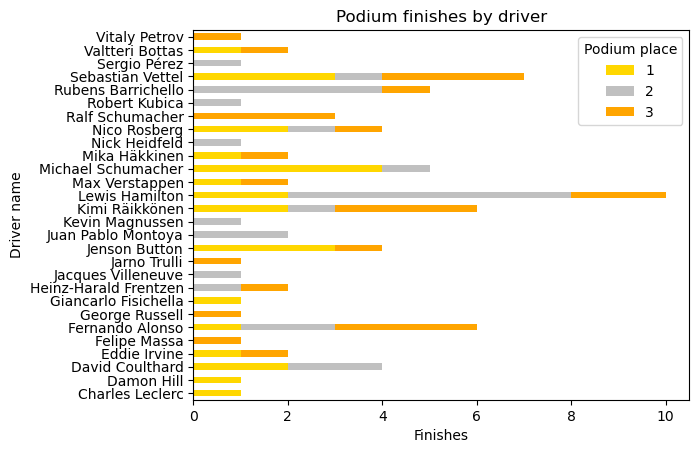

In [58]:
# Import pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt

# Define a list of colors for each positionOrder
colors = ["gold", "silver", "orange"]

# Plot the pivot table as a horizontal stacked barchart
podium_pivot.plot(kind="barh", stacked=True, color=colors)

# Set the title and axis labels
plt.title("Podium finishes by driver")
plt.xlabel("Finishes")
plt.ylabel("Driver name")

# Get the legend object and change its title
legend = plt.legend()
legend.set_title("Podium place")

# Show the plot
plt.show()

### Filter DataFrame for safety incidents

In [59]:
status = circuit_df[["driver_name", "year", "status"]]
status

,driver_name,year,status
0,Lewis Hamilton,2008,Finished
18,Lewis Hamilton,2007,Finished
35,Lewis Hamilton,2009,Disqualified
53,Lewis Hamilton,2010,Finished
71,Lewis Hamilton,2011,Finished
...,...,...,...
25960,Yuki Tsunoda,2022,+1 Lap
25982,Yuki Tsunoda,2023,Finished
25994,Nyck de Vries,2023,Collision
26038,Pascal Wehrlein,2016,+1 Lap


In [60]:
accident = status.query('status in ["Accident","Collision", "Spun off", "Fatal accident","Collision damage","Damage"]')
accident

,driver_name,year,status
145,Fernando Alonso,2016,Collision
223,Heikki Kovalainen,2009,Collision
2086,Nico Rosberg,2011,Collision
2222,Michael Schumacher,2011,Collision
2509,Robert Kubica,2008,Collision
...,...,...,...
15300,Jos Verstappen,1997,Spun off
15393,Toranosuke Takagi,1998,Spun off
21094,Esteban Gutiérrez,2016,Collision
21218,Kevin Magnussen,2023,Accident


### Create a pivot table for safety incidents

In [61]:
accident_pivot = accident.pivot_table(index="year", columns=["status"], aggfunc="size", fill_value=0)
accident_pivot

status,Accident,Collision,Damage,Spun off
year,,,,
1996,0,3,0,0
1997,0,3,0,2
1998,0,2,0,1
1999,0,3,0,1
2000,0,0,0,1
2001,0,2,0,1
2002,0,8,0,1
2003,2,0,0,1
2005,2,0,0,0


### Plotting a horizontal stacked bar chart of safety incidents

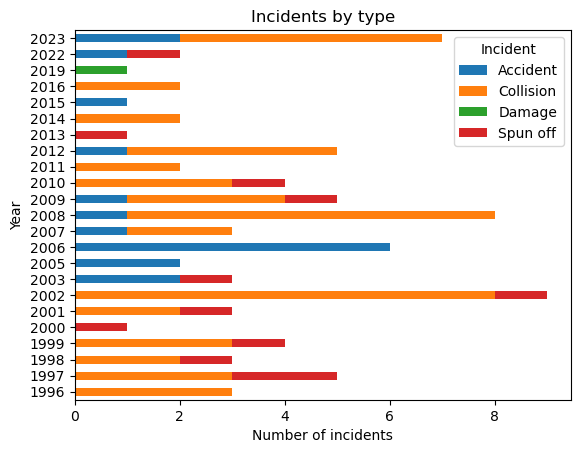

In [62]:
# Import pandas and matplotlib
import pandas as pd
import matplotlib.pyplot as plt

# Plot the pivot table as a horizontal stacked barchart
accident_pivot.plot(kind="barh", stacked=True)

# Set the title and axis labels
plt.title("Incidents by type")
plt.xlabel("Number of incidents")
plt.ylabel("Year")

# Get the legend object and change its title
legend = plt.legend()
legend.set_title("Incident")

# Show the plot
plt.show()

### Further safety metric - % of drivers finishing the race

In [63]:
finishers = len(circuit_df[circuit_df['statusId'] == 1])
finishers

215

In [64]:
starters = len(circuit_df.grid)
starters

558

In [65]:
finish_per_cent = round(finishers / starters * 100,2)
finish_per_cent

38.53

In [66]:
circuit_df.columns

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'positionDiff', 'status', 'year',
       'circuitId', 'race_name', 'race_date', 'circuit_name', 'location',
       'country', 'lat', 'lng', 'geometry', 'dob', 'driver_nat', 'driver_name',
       'constr_name', 'constr_nat'],
      dtype='object')

### Fastest Lap

We do not have legitimate fastest lap times for all drivers. Sometimes NAN values are used - in this case `\N` has been used. 

In [67]:
# Drop the missing values
circuit_df = circuit_df[circuit_df['fastestLapTime'] != '\\N']

In [68]:
circuit_df

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,location,country,lat,lng,geometry,dob,driver_nat,driver_name,constr_name,constr_nat
0,1,18,1,1,22,1,1,1,1,10.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),1985-01-07,British,Lewis Hamilton,McLaren,British
18,371,36,1,1,2,4,3,3,3,6.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),1985-01-07,British,Lewis Hamilton,McLaren,British
35,7573,1,1,1,1,18,\N,D,20,0.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),1985-01-07,British,Lewis Hamilton,McLaren,British
53,20352,338,1,1,2,11,6,6,6,8.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),1985-01-07,British,Lewis Hamilton,McLaren,British
71,20780,841,1,1,3,2,2,2,2,18.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),1985-01-07,British,Lewis Hamilton,McLaren,British
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25960,25460,1076,852,213,22,13,15,15,15,0.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),2000-05-11,Japanese,Yuki Tsunoda,AlphaTauri,Italian
25982,25895,1100,852,213,22,12,10,10,10,1.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),2000-05-11,Japanese,Yuki Tsunoda,AlphaTauri,Italian
25994,25900,1100,856,213,21,15,15,15,15,0.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),1995-02-06,Dutch,Nyck de Vries,AlphaTauri,Italian
26038,22932,948,836,209,94,21,16,16,16,0.0,...,Melbourne,Australia,-37.8497,144.968,POINT (144.968 -37.8497),1994-10-18,German,Pascal Wehrlein,Manor Marussia,British


In [69]:
fastest_lap = circuit_df[["driver_name", "fastestLapTime", "race_date"]]

In [70]:
# Group by fastestLapTime
fastest_lap = fastest_lap.groupby(by=["fastestLapTime"]).min()
fastest_lap

,driver_name,race_date
fastestLapTime,,
1:20.235,Sergio Pérez,2023-04-02
1:20.260,Charles Leclerc,2022-04-10
1:20.342,Max Verstappen,2023-04-02
1:20.467,Carlos Sainz,2023-04-02
1:20.476,Fernando Alonso,2023-04-02
...,...,...
1:41.351,Christian Klien,2006-04-02
1:43.132,Vitaly Petrov,2010-03-28
1:43.223,Adrian Sutil,2010-03-28


In [71]:
# get fastest lap time from the first value [0] of the index [fastestLapTime]
fastest_lap_time = fastest_lap.index[0]
fastest_lap_time

'1:20.235'

In [72]:
# get fastest driver from the first value [0] of driver_name
fastest_lap_driver = fastest_lap.driver_name[0]
fastest_lap_driver

'Sergio Pérez'

In [73]:
# get date of fastest lap from the first value [0] of race_date
fastest_lap_date = fastest_lap.race_date[0]
fastest_lap_date

'2023-04-02'

### Streamlit

Now that we have decided on the features of interest and how we would like to present them it's time to pull everything together and create a working app that users can interact with.

Streamlit is a Python library that allows you to create web-apps and dashboard by just writing Python code. It provides you with a wide range of UI widgets and layouts that can be used to build user- interfaces. Your streamlit app is just a regular Python file with a `.py` extension.

Streamlit is fantastic because it allows you to preview your app in the browser, as you code it. Any changes you make are immediately appplied to the app in real time, which is invaluable for debugging. You can slowy build, test, debug, build test ensuring there are no unexpected glitches on final deployment. 

### Installation and Setting up the Environment

You need to install the streamlit package to create the app. We will be using Anaconda to install streamlit and related packages on your machine. Please review the [Anaconda Installation Guide]((https://courses.spatialthoughts.com/python-foundation.html#installation-and-setting-up-the-environment)) for step-by-step instructions.

1. Once you have installed Anaconda, open Anaconda Prompt or a Terminal and run the following commands :

In [ ]:
conda update --all
conda create --name streamlit -y
conda activate streamlit

2. Now your environment is ready. We will install the required packages. First install geopandas :

In [ ]:
conda install -c conda-forge geopandas  -y

3. Next we will install streamlit and leafmap.

In [ ]:
pip install streamlit streamlit-folium leafmap

4. After the installation is done, run the following command :

In [ ]:
streamlit hello

A new browser tab will open and display the streamlit Hello app.

Your installation is now complete. You can close the terminal window to stop the streamlit server.

### Creating our Streamlit app

All the hard work has been done, it's the last lap and the chequered flag is in sight! 

To view a working prototype locally in our browser, simply navigate to the directory where the `app.py` file is and run the following from the command line :

In [ ]:
streamlit run app.py

`app.py`

In [ ]:
import streamlit as st
import geopandas as gpd
from geojson import Feature, Point, FeatureCollection
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import leafmap.foliumap as leafmap
import altair as alt

# cosmetic config
st.set_page_config(page_title='Dashboard', layout='wide')

st.title('Formula One - Data Pitstop - 1950 to 2023')

st.sidebar.title('About')
st.sidebar.info('F1 stats and maps for 35 race circuits')

# Add a dropdown to enable user to choose type of basemap  
base_map = st.selectbox('Select a basemap', ['OpenStreetMap', 'Stamen Terrain', 'Stamen Toner'])

# specify file path and filenames
data_url = 'https://raw.githubusercontent.com/Stephen137/formula_one/main/data/'
geojson_file = 'f1-circuits.geojson'
csv_file = 'f1_summary.csv'

@st.cache_data
# custom function to load in our spatial data
def read_gdf(url):
    gdf = gpd.read_file(url)
    return gdf

@st.cache_data
# custom function to load circuit statistics
def read_csv(url):
    df = pd.read_csv(url)
    return df

# Process start
data_load_state = st.text('Engines revving...')  

# Concatenate file names
geojson_url = data_url + geojson_file
f1_summary_url = data_url + csv_file

# create circuits GeoDataFrame
circuits_gdf = read_gdf(geojson_url)

# create non spatial F1 stats DataFrame
f1_stats_df = read_csv(f1_summary_url)

# Process complete
data_load_state.text('Lights out and away we go ... !')

# add a dropdown for circuit selection and filter dataset based on user choice
circuits = circuits_gdf.sort_values(by="Name").Name.unique()
# circuits = f1_stats_df.sort_values(by="circuit_name").circuit_name.unique()
circuit = st.sidebar.selectbox('Select a Circuit', circuits)

circuit_df = f1_stats_df[f1_stats_df['circuit_name'] == circuit]

# create a map
m = leafmap.Map(
    layers_control=True,
    draw_control=False,
    measure_control=False,
    fullscreen_control=False,
    tiles=base_map,
    hover_style={"fillOpacity": 0.7},
)

# add circuits layer
m.add_gdf(
    gdf=circuits_gdf,
    zoom_to_layer=False,
    layer_name='circuits',
    info_mode='on_hover',
    style={'color': '#7fcdbb', 'fillOpacity': 0.3, 'weight': 0.5},
    hover_style={"fillOpacity": 0.7},
    )

# filter for user circuit selection
selected_gdf = circuits_gdf[circuits_gdf['Name'] == circuit]

# add the user selected circuits layer
m.add_gdf(
    gdf=selected_gdf,
    layer_name='selected',
    zoom_to_layer=True,
    info_mode='on_hover',
    style={'color': 'red', 'fill': None, 'weight': 2},
    hover_style={"fillOpacity": 0.7},
 )

m_streamlit = m.to_streamlit(600, 600)

# Drop invalid values 
circuit_df = circuit_df[circuit_df['fastestLapTime'] != '\\N']

# filter for fastest lap
fastest_lap = circuit_df[["driver_name", "fastestLapTime", "race_date"]]
fastest_lap = fastest_lap.groupby(by=["fastestLapTime"]).min()

# fastest lap details based on user circuit selection
# deal with potential errors by allowing our code to continue to be executed
try:
    fastest_lap_time = fastest_lap.index[0]
except IndexError:
    pass
try:
    fastest_lap_driver = fastest_lap.driver_name[0]
except IndexError:
    pass
try:
    fastest_lap_date = fastest_lap.race_date[0]
except:
    pass

try: 
    st.text(f'The fastest lap time recorded at {circuit} is {fastest_lap_time}, clocked by {fastest_lap_driver} on {fastest_lap_date}.')
except NameError:
    pass
st.text(f'The bar chart below provides a breakdown of the champagne soaked podium finishers : ')

# add a stacked horizontal bar chart to show podium finishes for selected circuit
position = circuit_df[["driver_name", "positionOrder"]]
podium = position.query('positionOrder in [1,2,3]') 

podium_pivot = podium.pivot_table(index="driver_name", columns="positionOrder", aggfunc="size", fill_value=0)

st.bar_chart(podium_pivot)


st.text(f'The bar chart below shows the number of major incidents by year : ')

# add a stacked horizontal bar chart to show serious accidents for selected circuit
status = circuit_df[["driver_name", "year", "status"]]
accident = status.query('status in ["Accident","Collision", "Spun off", "Fatal accident","Collision damage","Damage"]')

accident_pivot = accident.pivot_table(index="year", columns="status", aggfunc="size", fill_value=0)

st.bar_chart(accident_pivot)

# Percentage of drivers who finish a race for chosen circuit
starters = len(circuit_df.grid)
finishers = len(circuit_df[circuit_df['statusId'] == 1])

# deal with potential errors by allowing our code to continue to be executed
try:
    finish_per_cent = round(finishers / starters * 100,2)
except ZeroDivisionError:
    pass
try:
    st.text(f'From a total of {starters} drivers who have started a race at {circuit}, {finish_per_cent} % completed the race.')
except ZeroDivisionError:
    pass
except NameError:
    pass

### Publishing our app with Streamlit Cloud

Streamlit provides free hosting for your streamlit apps. In this section, we will now learn how to deploy an app to Streamlit cloud and configure it correctly.

### Upload the app to GitHub

To run your app on Streamlit Cloud, you need to upload your app to GitHub. Streamlit supports both private and public repositories. 

### Add App dependencies

If your app needs a third-party Python package, you need to add it in a separate file called `requirements.txt`. The packages listed in the file will be installed on Streamlit Cloud before running the app.

For our app, we have created the `requirements.txt` file with the following content and uploaded it to GitHub in the same directory as the `app.py`.

`requirements.txt`

In [ ]:
streamlit
folium
streamlit-folium

You may also specify other dependencies for your app. Learn more at [App dependencies](https://docs.streamlit.io/streamlit-cloud/get-started/deploy-an-app/app-dependencies) documentation.

### Replace Sensitive Data with Secrets

It is not a good practice to store API keys or passwords in the code as it can be seen by others and can be misused. Streamlit provides an easy way for [Secrets Management](https://docs.streamlit.io/streamlit-cloud/get-started/deploy-an-app/connect-to-data-sources/secrets-management). You can store any `key=value` pairs in a separate location and access it in the app using `st.secrets`.

While doing local development, you create a folder named `.streamlit` in the app directory and store any `key=value` pairs in a file named `secrets.toml`. For example, if you want to store the ORS API Key, you can create a new file `secrets.toml` in the `.streamlit directory` with the following content. (Replace <your api key> with the actual key).

In [ ]:
'ORS_API_KEY' = '<your api key>'

### Deploy your App

Now you are ready to deploy your app to Streamlit Cloud.

1. Visit [Streamlit Cloud](https://streamlit.io/cloud) and sign-in. If you do not have an account, you can click *Sign-up* and create a new account. Once logged-in, click the *New app* button.

2. Click Paste GitHub URL and paste the URL to your streamlit app.py file. For my example, this is `f1_app.py` but you should select you own.  Next, click *Advanced settings* :

3. This dialog allows you to store your private information required by your apps, such as API keys, username/password for your database, etc. For my example I don't require to enter anything, however if your app does require an API key, then you need to enter the API Key in the following format and replace with your actual API key. Click Save.

In [ ]:
'ORS_API_KEY' = '<your key>'

4. You are now ready to deploy the app. Click *Deploy!* 

5. Your app will now be deployed and will be accessible via the provided URL. You can visit your Dashboard to manage the app once it is deployed.

The app is now live! Visit the [F1 app](https://f1apppy-6oapycqh3zokdnwcvxjbqi.streamlit.app/) to see it in action!